<a href="https://colab.research.google.com/github/abdulquawiyy-owolabi/Deep-Learning/blob/main/Copy_of_Unsupervised_Learning_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install dependencies

import os, sys, shutil, importlib

REPO_PATH = "neuromatch_ssl_tutorial"
download_str = "Downloading"
if os.path.exists(REPO_PATH):
  download_str = "Redownloading"
  shutil.rmtree(REPO_PATH)

# Download from github repo directly
# !git clone git://github.com/colleenjg/neuromatch_ssl_tutorial.git --quiet

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://osf.io/smqvg/download'
print(f"{download_str} and unzipping the file... Please wait.")
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Correct now-broken use of deprecated np.product method
for module in ["data.py", "load.py", "models.py"]:
  with open(f"neuromatch_ssl_tutorial/modules/{module}", "r") as f:
    source = f.read()
    source = source.replace("np.product(", "np.prod(")
    with open(f"neuromatch_ssl_tutorial/modules/{module}", "w") as f:
      f.write(source)

print("Download completed!")

Download completed!


In [2]:
# Imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Import modules designed for use in this notebook.
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
importlib.reload(data)
importlib.reload(load)
importlib.reload(models)
importlib.reload(plot_util)

<module 'neuromatch_ssl_tutorial.modules.plot_util' from '/content/neuromatch_ssl_tutorial/modules/plot_util.py'>

In [3]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

plt.rc('axes', unicode_minus=False) # To ensure negatives render correctly with xkcd style
import warnings
warnings.filterwarnings("ignore")

In [4]:
# @title Plotting functions

# @markdown Function to plot a histogram of RSM values: `plot_rsm_histogram(rsms, colors)`
def plot_rsm_histogram(rsms, colors, labels=None, nbins=100):
  """
  Function to plot histogram based on Representational Similarity Matrices

  Args:
    rsms: List
      List of values within RSM
    colors: List
      List of colors for histogram
    labels: List
      List of RSM Labels
    nbins: Integer
      Specifies number of histogram bins

  Returns:
    Nothing
  """
  fig, ax = plt.subplots(1)
  ax.set_title("Histogram of RSM values", y=1.05)

  min_val = np.min([np.nanmin(rsm) for rsm in rsms])
  max_val = np.max([np.nanmax(rsm) for rsm in rsms])

  bins = np.linspace(min_val, max_val, nbins+1)

  if labels is None:
    labels = [labels] * len(rsms)
  elif len(labels) != len(rsms):
    raise ValueError("If providing labels, must provide as many as RSMs.")

  if len(rsms) != len(colors):
    raise ValueError("Must provide as many colors as RSMs.")

  for r, rsm in enumerate(rsms):
    ax.hist(
        rsm.reshape(-1), bins, density=True, alpha=0.4,
        color=colors[r], label=labels[r]
        )
  ax.axvline(x=0, ls="dashed", alpha=0.6, color="k")
  ax.set_ylabel("Density")
  ax.set_xlabel("Similarity values")
  ax.legend()
  plt.show()

In [5]:
# @title Helper functions

from IPython.display import display, Image # to visualize images

def test_custom_torch_RSM_fct(custom_torch_RSM_fct):
  """
  Function to set test implementation of custom_torch_RSM_fct

  Args:
    custom_torch_RSM_fct: f_name
      Function to test

  Returns:
    Nothing
  """
  rand_feats = torch.rand(100, 1000)
  RSM_custom = custom_torch_RSM_fct(rand_feats)
  RSM_ground_truth = data.calculate_torch_RSM(rand_feats)

  if torch.allclose(RSM_custom, RSM_ground_truth, equal_nan=True):
    print("custom_torch_RSM_fct() is correctly implemented.")
  else:
    print("custom_torch_RSM_fct() is NOT correctly implemented.")


# @markdown Function to set test custom contrastive loss function: `test_custom_contrastive_loss_fct()`
def test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss):
  """
  Function to set test implementation of custom_simclr_contrastive_loss

  Args:
    custom_simclr_contrastive_loss: f_name
      Function to test

  Returns:
    Nothing
  """
  rand_proj_feat1 = torch.rand(100, 1000)
  rand_proj_feat2 = torch.rand(100, 1000)
  loss_custom = custom_simclr_contrastive_loss(rand_proj_feat1, rand_proj_feat2)
  loss_ground_truth = models.contrastive_loss(rand_proj_feat1,rand_proj_feat2)

  if torch.allclose(loss_custom, loss_ground_truth):
    print("custom_simclr_contrastive_loss() is correctly implemented.")
  else:
    print("custom_simclr_contrastive_loss() is NOT correctly implemented.")

In [6]:
# @title Set random seed

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
# Set global variables
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [9]:
# @title ### Pre-load variables (allows each section to be run independently)

# Section 1
dSprites = data.dSpritesDataset(
    os.path.join(REPO_PATH, "dsprites", "dsprites_subset.npz")
    )

dSprites_torchdataset = data.dSpritesTorchDataset(
  dSprites,
  target_latent="shape"
  )

train_sampler, test_sampler = data.train_test_split_idx(
  dSprites_torchdataset,
  fraction_train=0.8,
  randst=SEED
  )

supervised_encoder = load.load_encoder(REPO_PATH,
                                       model_type="supervised",
                                       verbose=False)

# Section 2
custom_torch_RSM_fct = None  # Default is used instead

# Section 3
random_encoder = load.load_encoder(REPO_PATH,
                                   model_type="random",
                                   verbose=False)

# Section 4
vae_encoder = load.load_encoder(REPO_PATH,
                                model_type="vae",
                                verbose=False)

# Section 5
invariance_transforms = torchvision.transforms.RandomAffine(
    degrees=90,
    translate=(0.2, 0.2),
    scale=(0.8, 1.2)
    )
dSprites_invariance_torchdataset = data.dSpritesTorchDataset(
    dSprites,
    target_latent="shape",
    simclr=True,
    simclr_transforms=invariance_transforms
    )

# Section 6
simclr_encoder = load.load_encoder(REPO_PATH,
                                   model_type="simclr",
                                   verbose=False)

In [10]:
dSprites = data.dSpritesDataset(
    os.path.join(REPO_PATH, 'dsprites', 'dsprites_subset.npz')
)

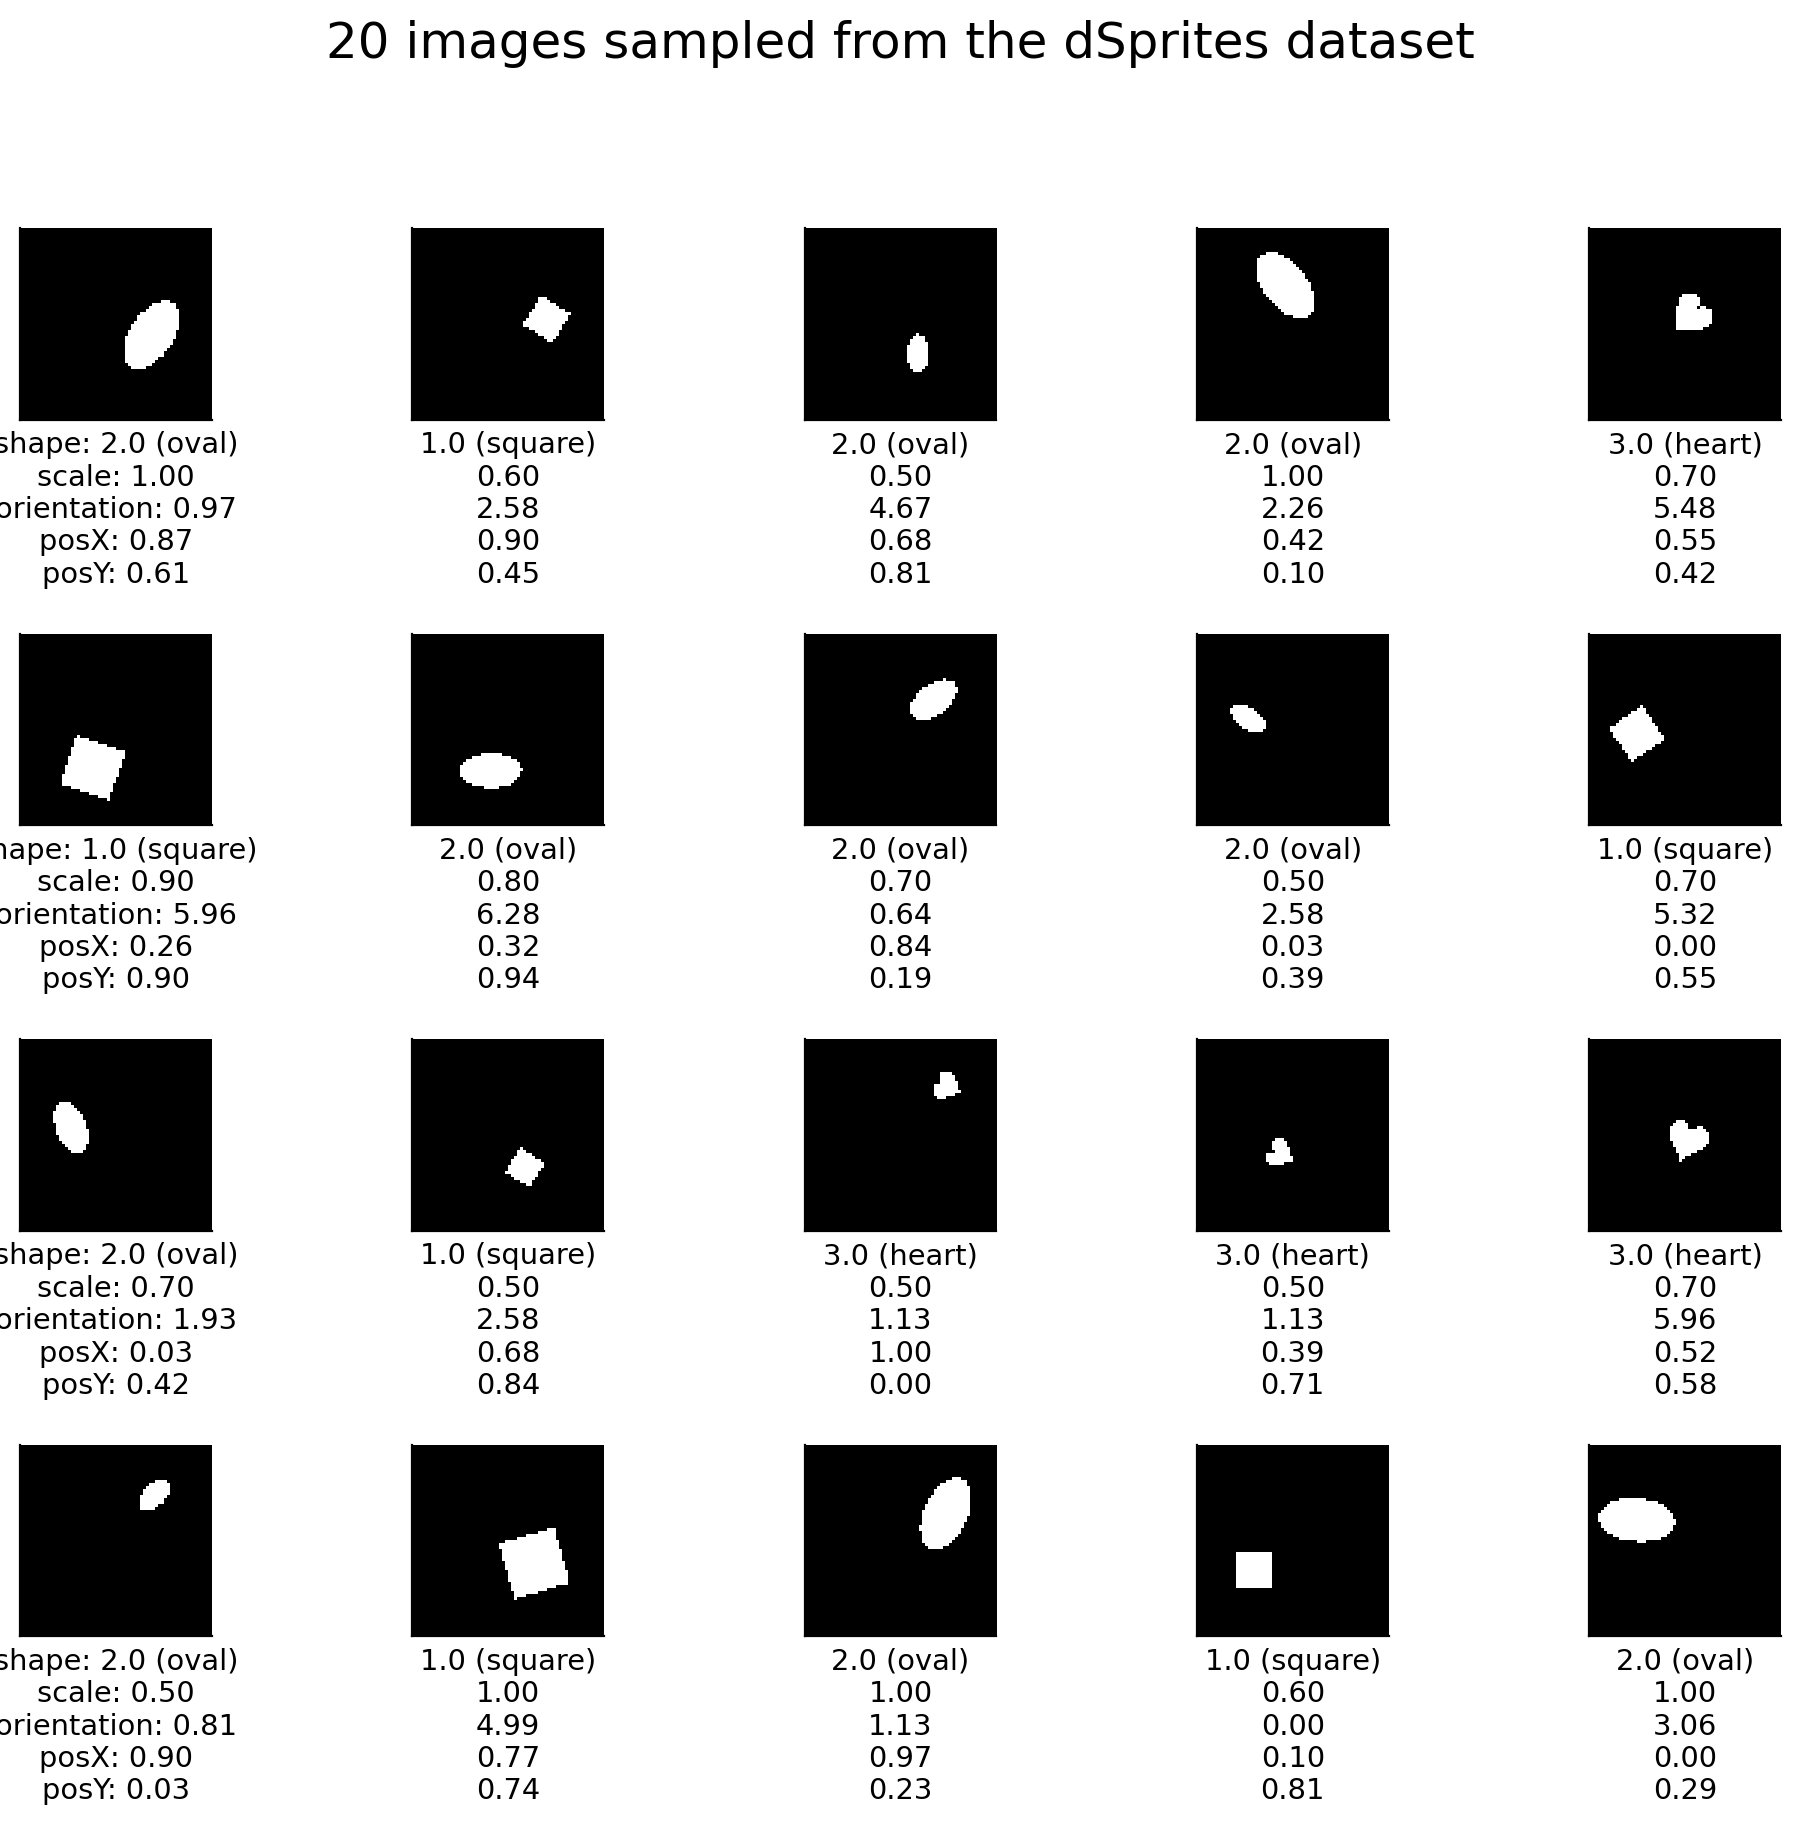

In [11]:
dSprites.show_images(num_images=20, randst=SEED)

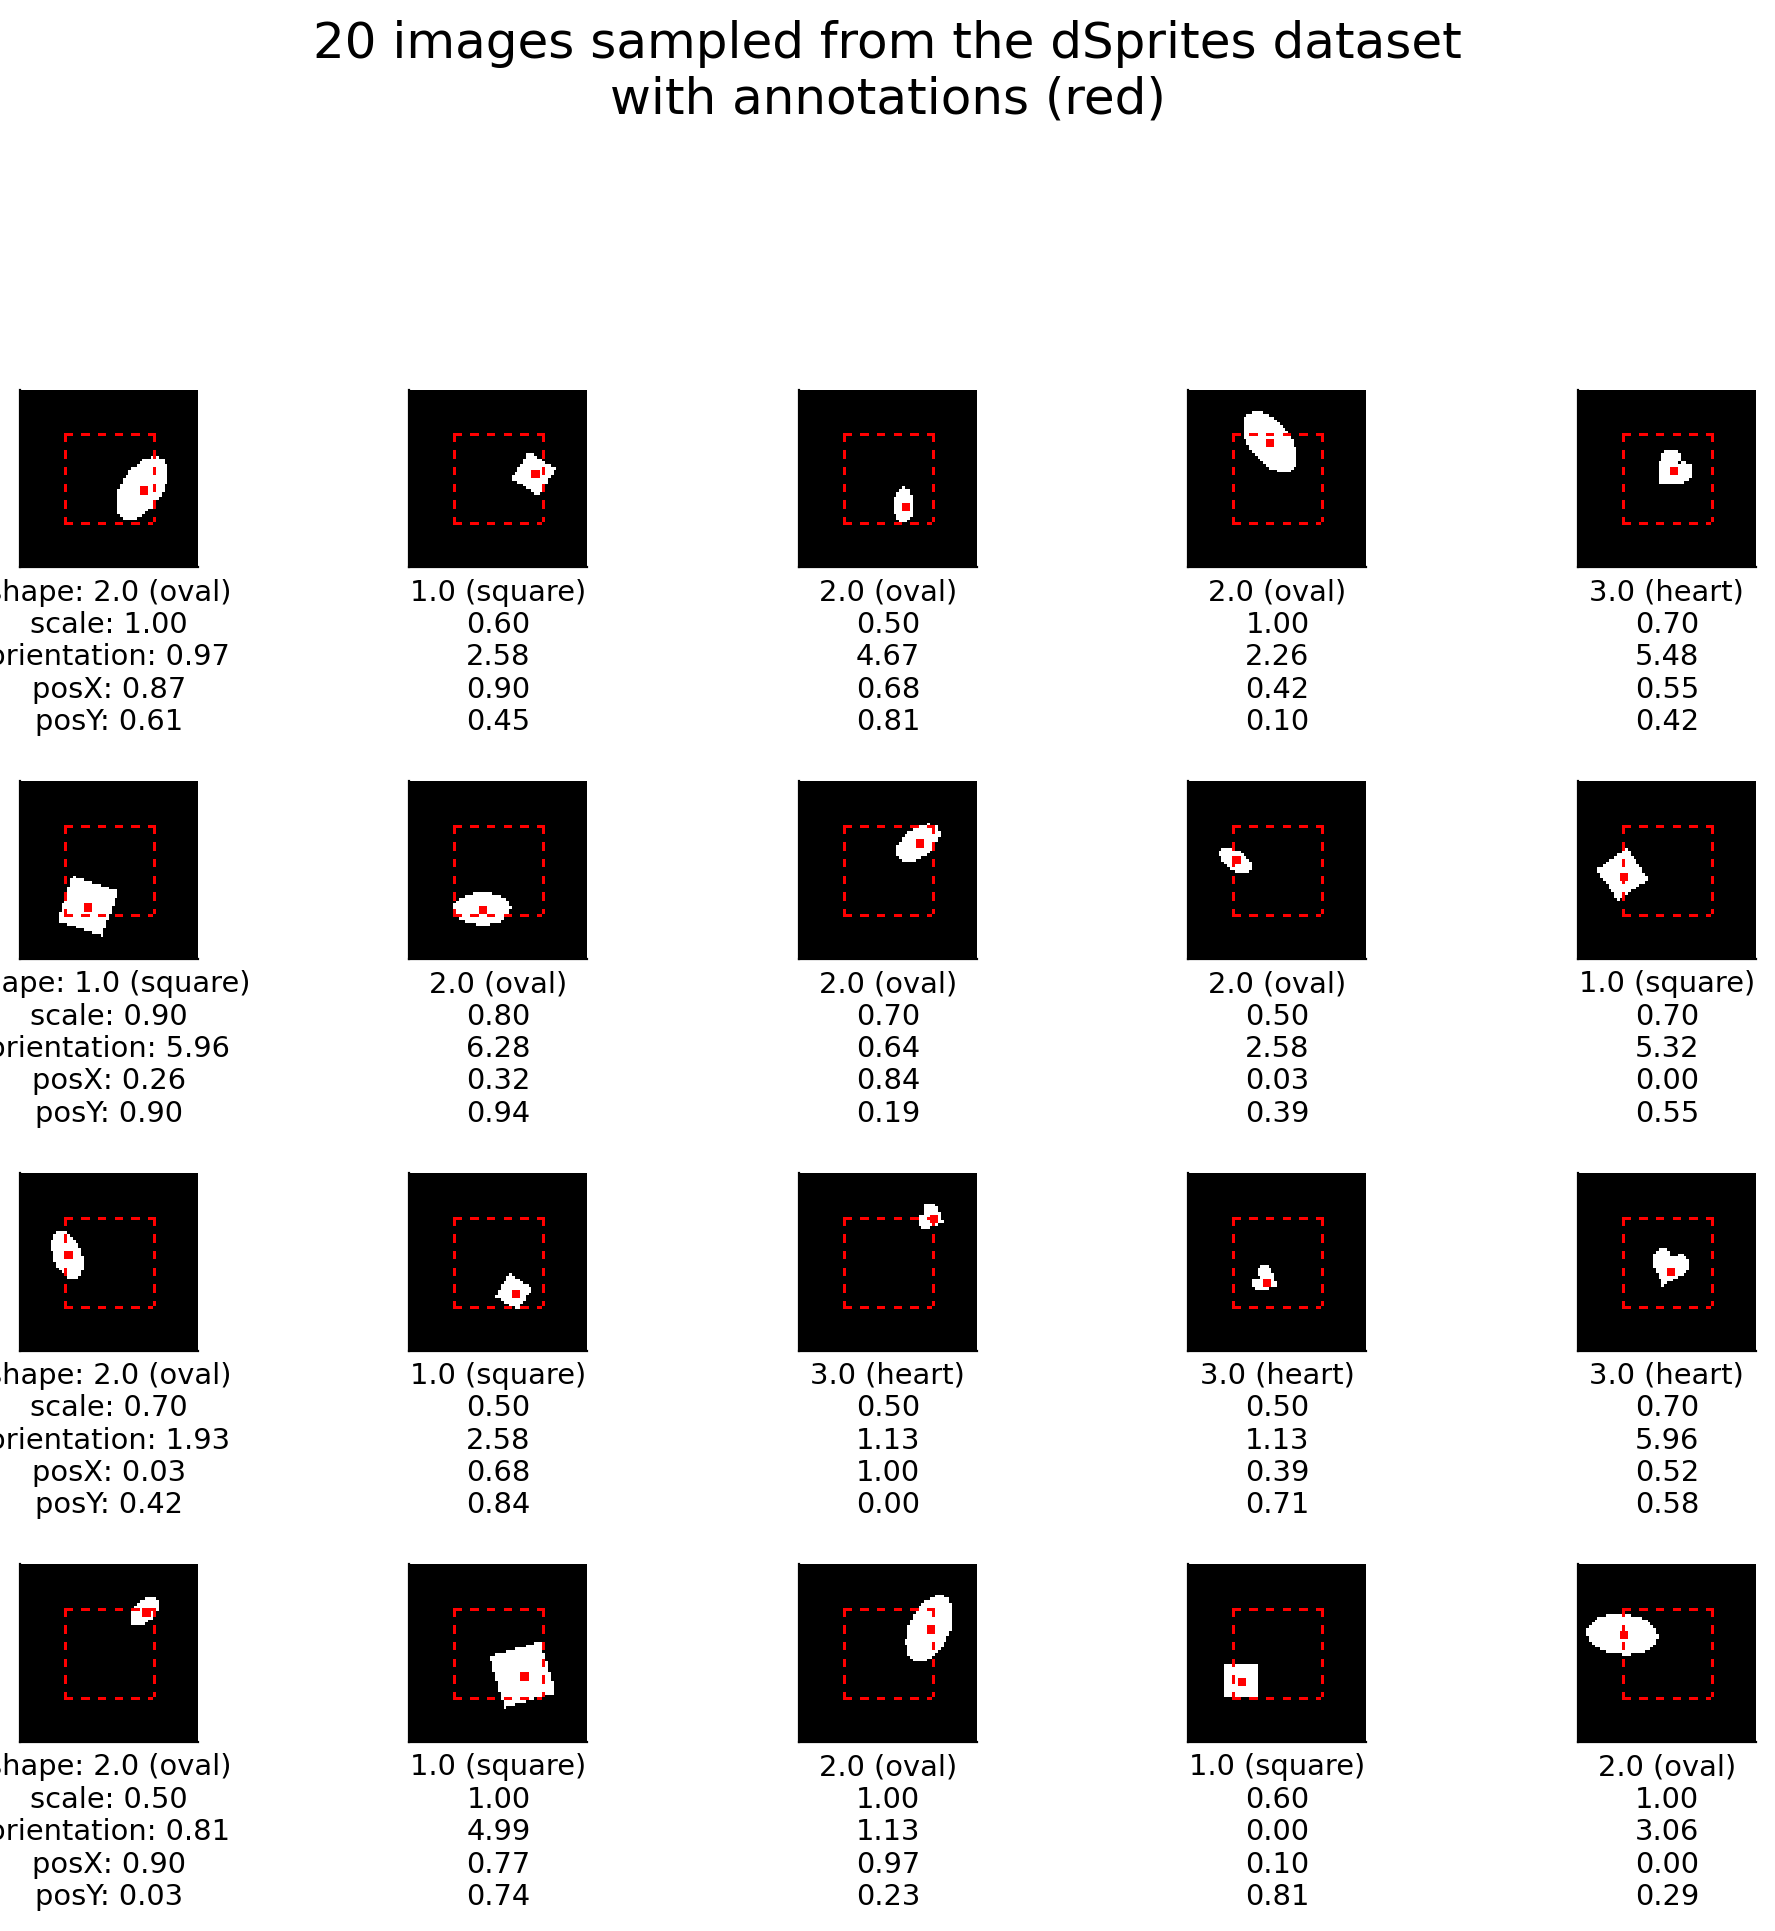

In [12]:
dSprites.show_images(num_images=20, randst=SEED, annotations='pos')

In [13]:
 # Set the seed before building any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# Initialize a torch dataset, specifying the target latent dimension for
# the classifier
dSprites_torchdataset = data.dSpritesTorchDataset(
  dSprites,
  target_latent="shape"
  )

# Initialize a train_sampler and a test_sampler to keep the two sets
# consistently separate
train_sampler, test_sampler = data.train_test_split_idx(
  dSprites_torchdataset,
  fraction_train=0.8,  # 80:20 data split
  randst=SEED
  )

print(f"Dataset size: {len(train_sampler)} training, "
      f"{len(test_sampler)} test images")

Random seed 2021 has been set.
Dataset size: 16000 training, 4000 test images


In [14]:
# Call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

num_epochs = 50  # DEMO: Try different numbers of training epochs

# Train a classifier directly on the images
print("Training a classifier directly on the images...")
_ = models.train_classifier(
  encoder=None,
  dataset=dSprites_torchdataset,
  train_sampler=train_sampler,
  test_sampler=test_sampler,
  freeze_features=True,  # There is no feature encoder to train here, anyway
  num_epochs=num_epochs,
  verbose=True  # Print results
  )

Random seed 2021 has been set.
Training a classifier directly on the images...


  0%|          | 0/50 [00:00<?, ?it/s]

Network performance after 50 classifier training epochs (chance: 33.33%):
    Training accuracy: 54.32%
    Testing accuracy: 40.58%


In [15]:
# Call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# Load VAE encoder and decoder pre-trained on the reconstruction and KLD tasks
vae_encoder = load.load_encoder(REPO_PATH, model_type="vae")
vae_decoder = load.load_vae_decoder(REPO_PATH)

Random seed 2021 has been set.
Loading VAE encoder from 'neuromatch_ssl_tutorial/checkpoints/vae_encoder_300ep_bs500_seed2021.pth'.
    => trained for 300 epochs (batch_size of 500) on the full dSprites subset dataset.
Loading VAE decoder from 'neuromatch_ssl_tutorial/checkpoints/vae_decoder_300ep_bs500_seed2021.pth'.
   => trained for 300 epochs (batch_size of 500) on the full dSprites subset dataset.


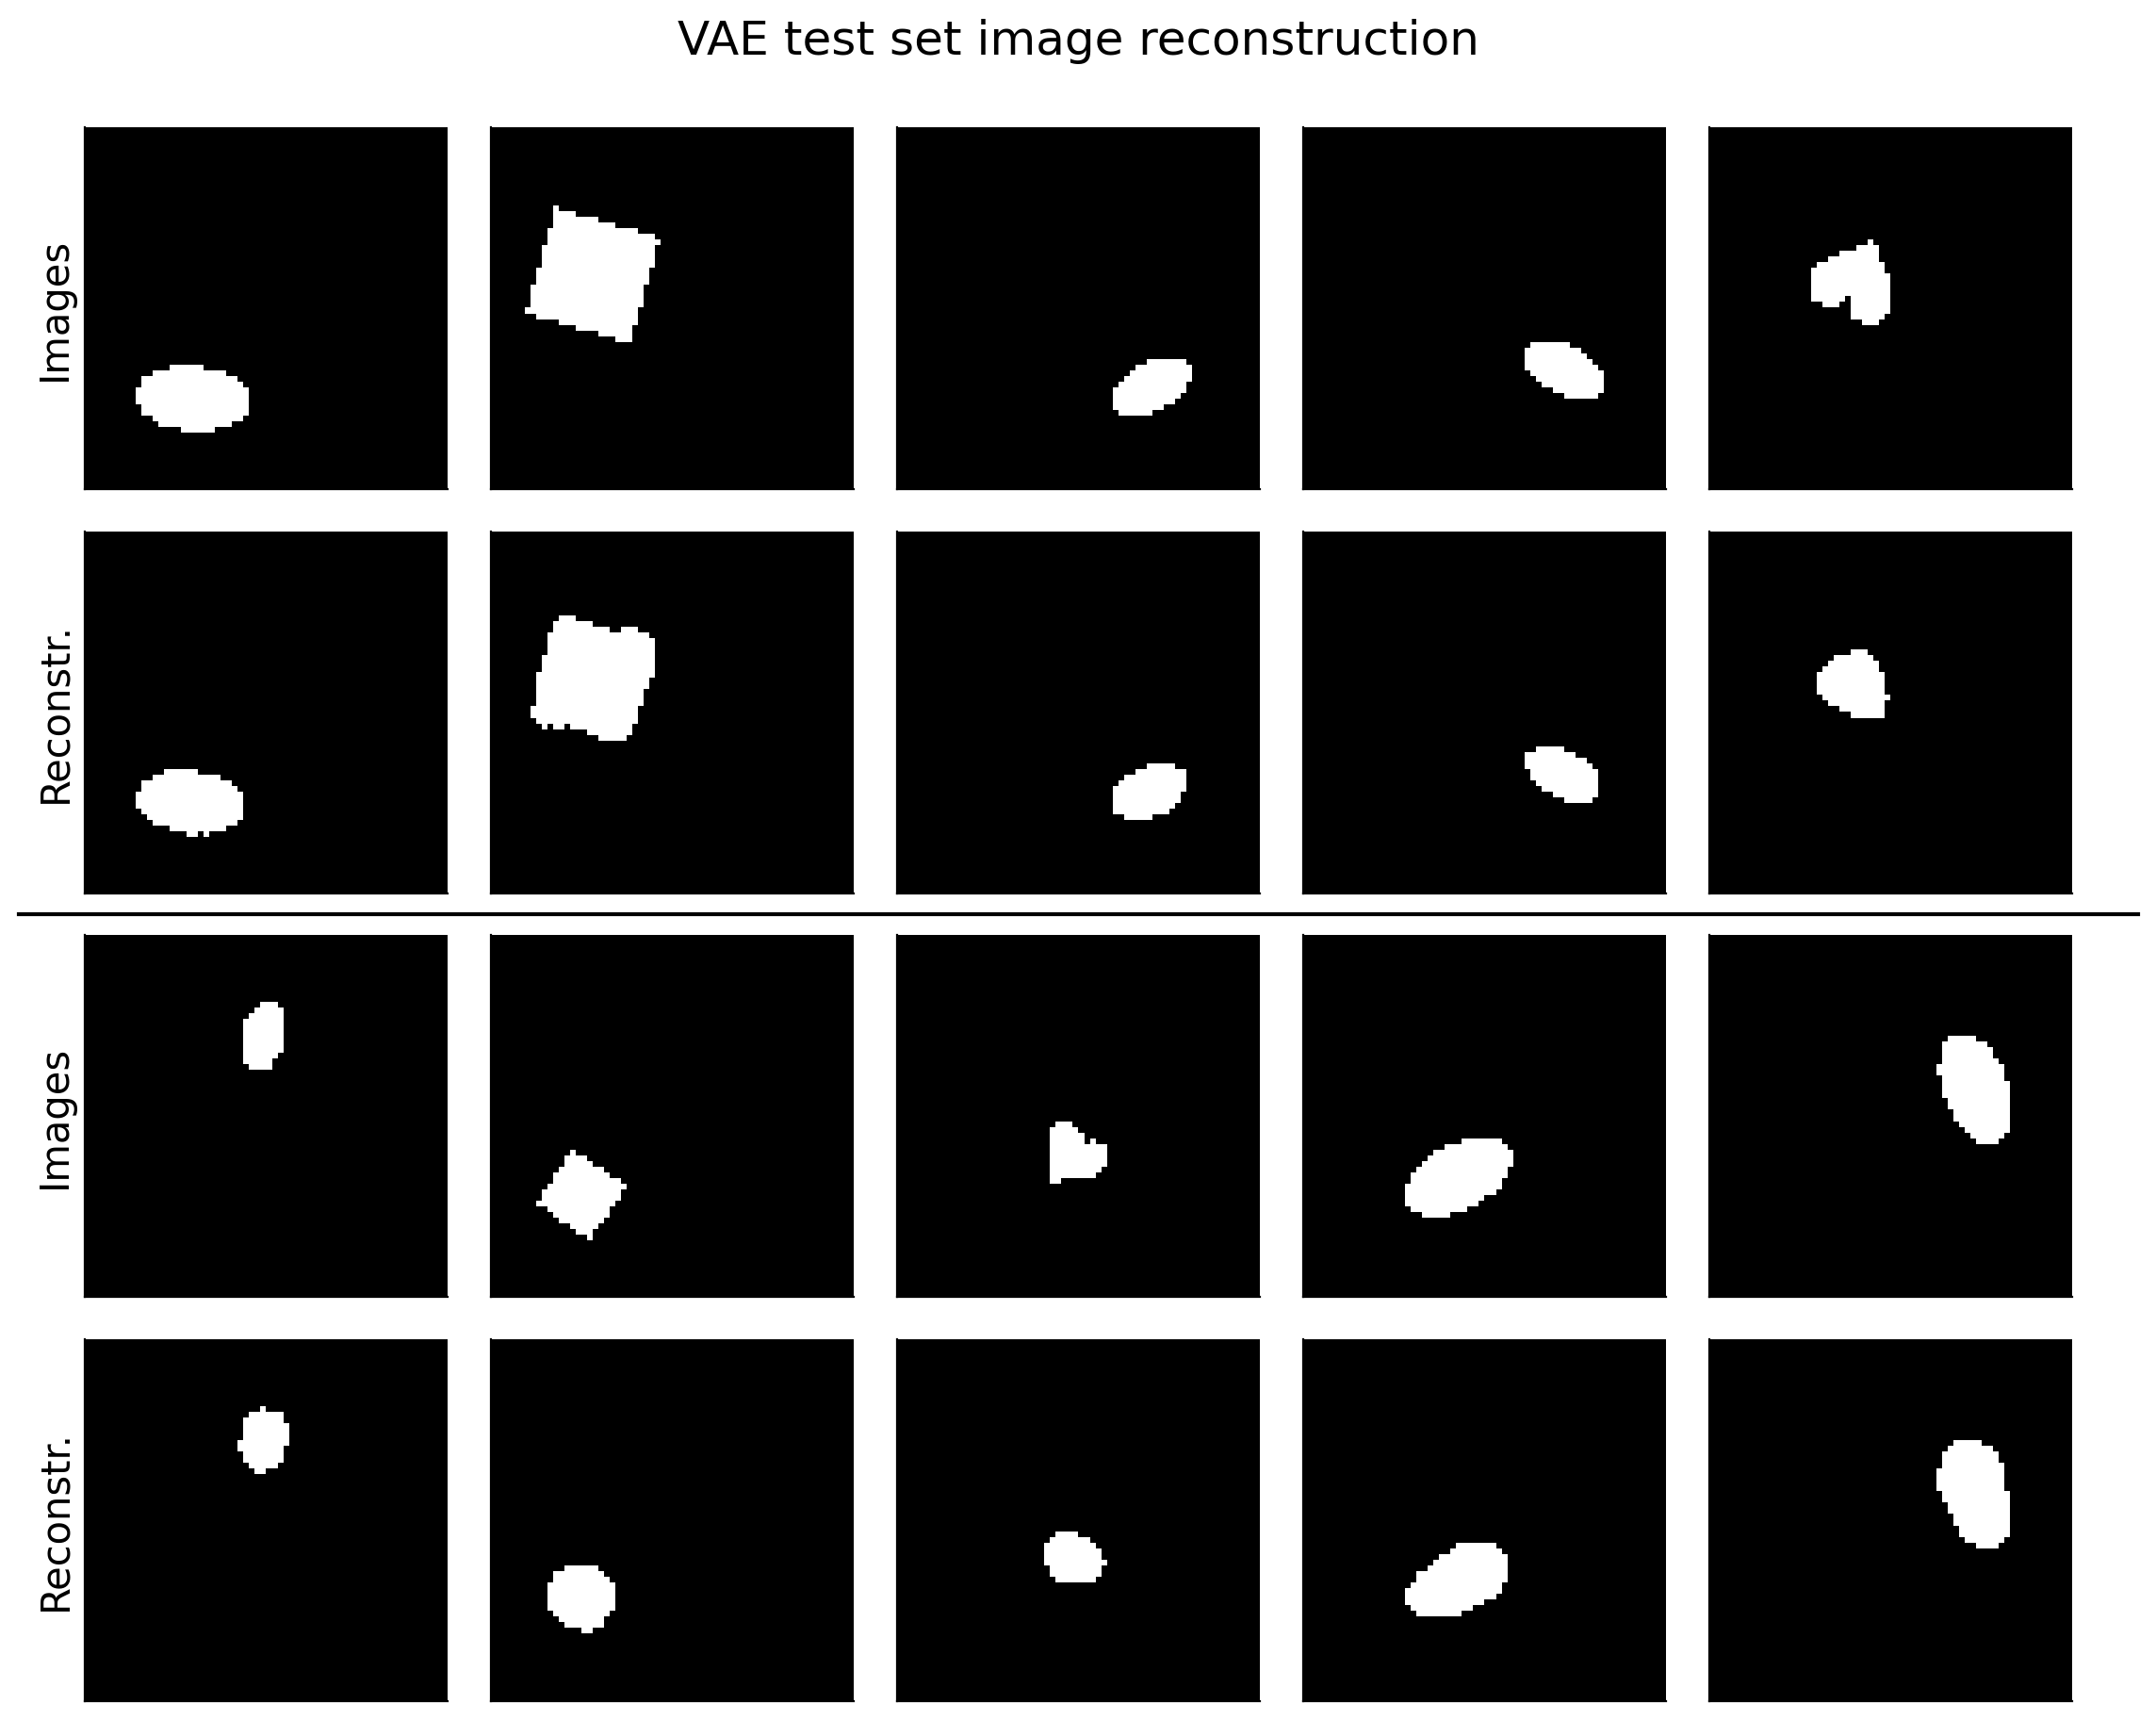

In [17]:
models.plot_vae_reconstructions(
    vae_encoder,
    vae_decoder,
    dataset=dSprites_torchdataset,
    indices=test_sampler.indices[:10],
    title='VAE test set image reconstruction'
)

Plotting RSMs...


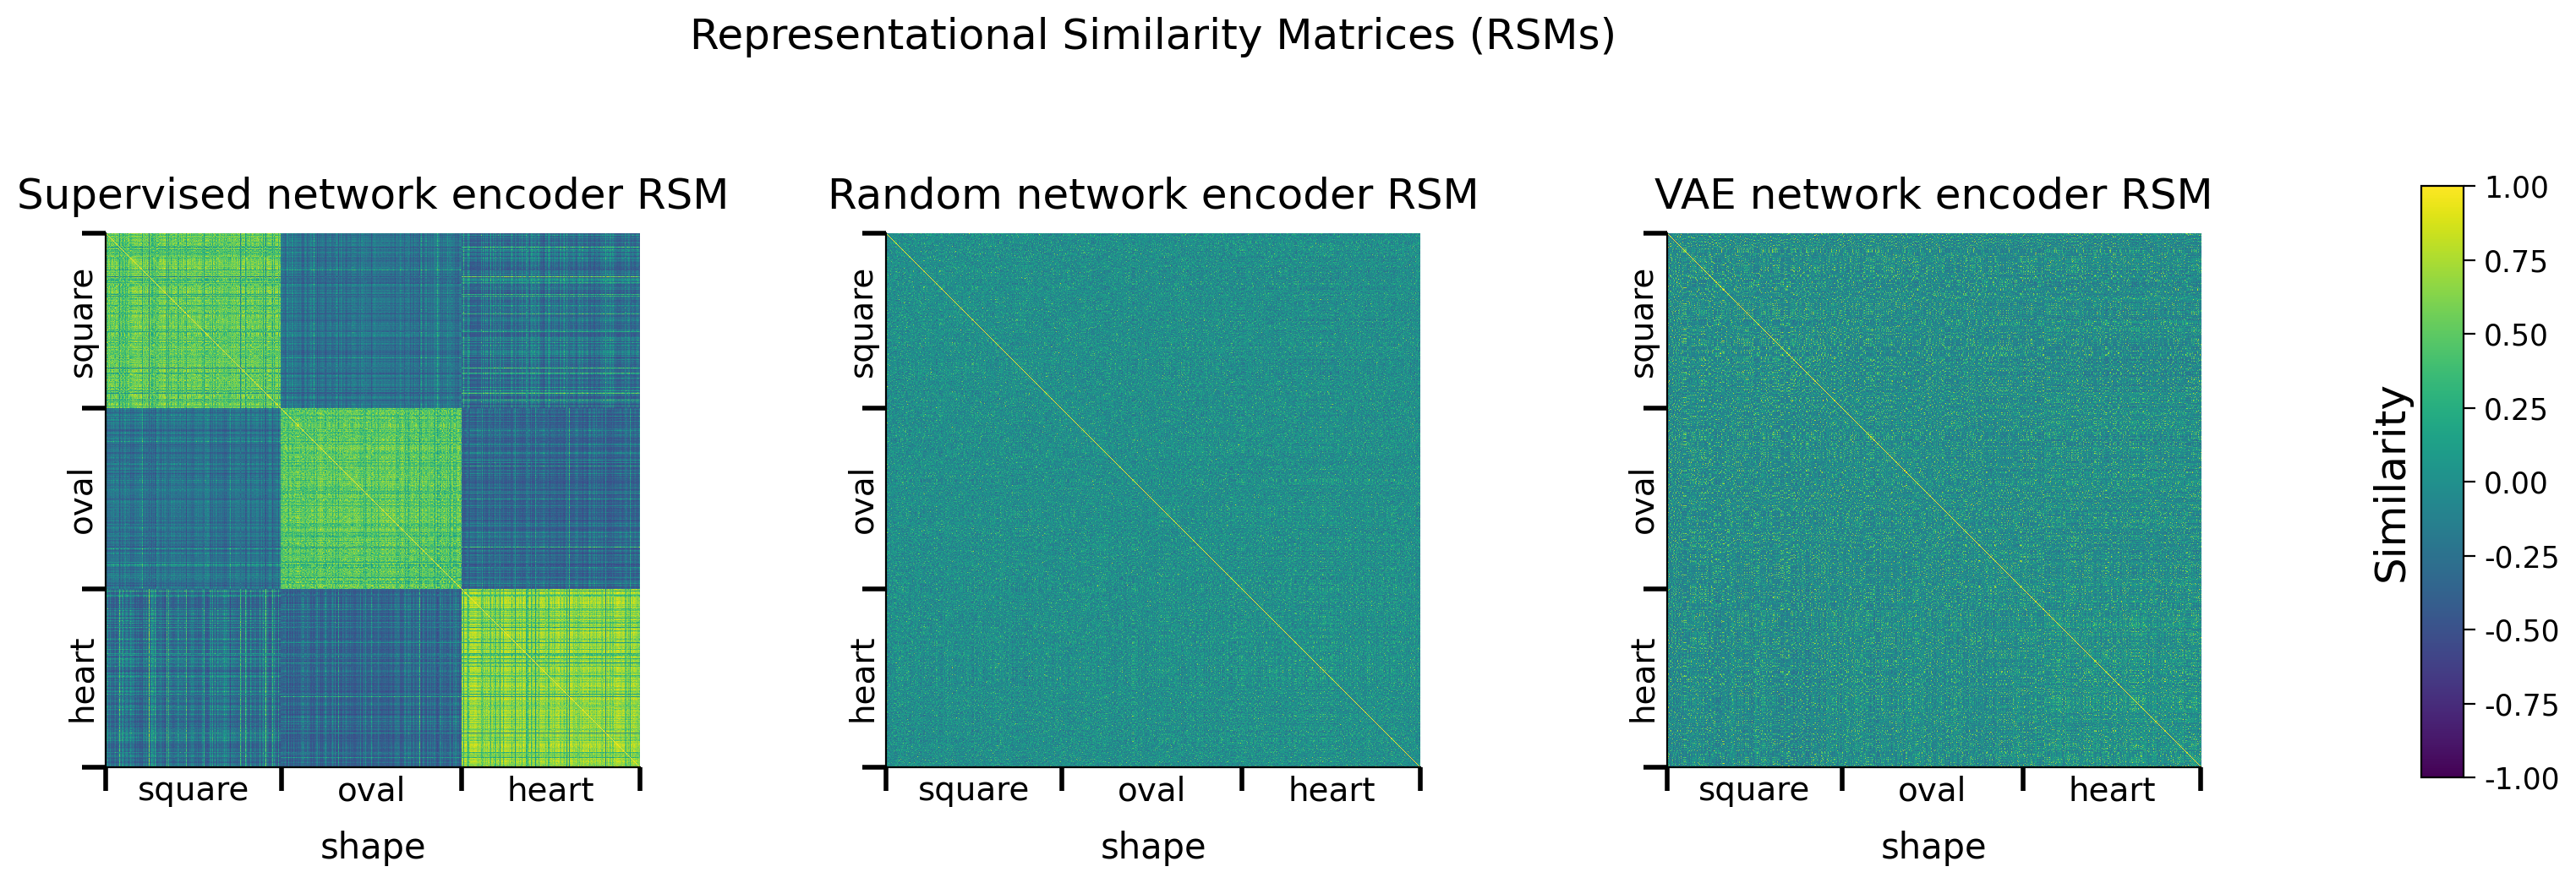

In [18]:
sorting_latent = "shape"  # DEMO: Try sorting by different latent dimensions
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, random_encoder, vae_encoder],  # Pass all three encoders
    dataset=dSprites_torchdataset,
    sampler=test_sampler,  # To see the representations on the held out test set
    titles=["Supervised network encoder RSM", "Random network encoder RSM",
            "VAE network encoder RSM"],  # Plot titles
    sorting_latent=sorting_latent,
    )

Random seed 2021 has been set.
Training a classifier on the pre-trained VAE encoder representations...


  0%|          | 0/25 [00:00<?, ?it/s]

Network performance after 25 classifier training epochs (chance: 33.33%):
    Training accuracy: 46.48%
    Testing accuracy: 45.75%


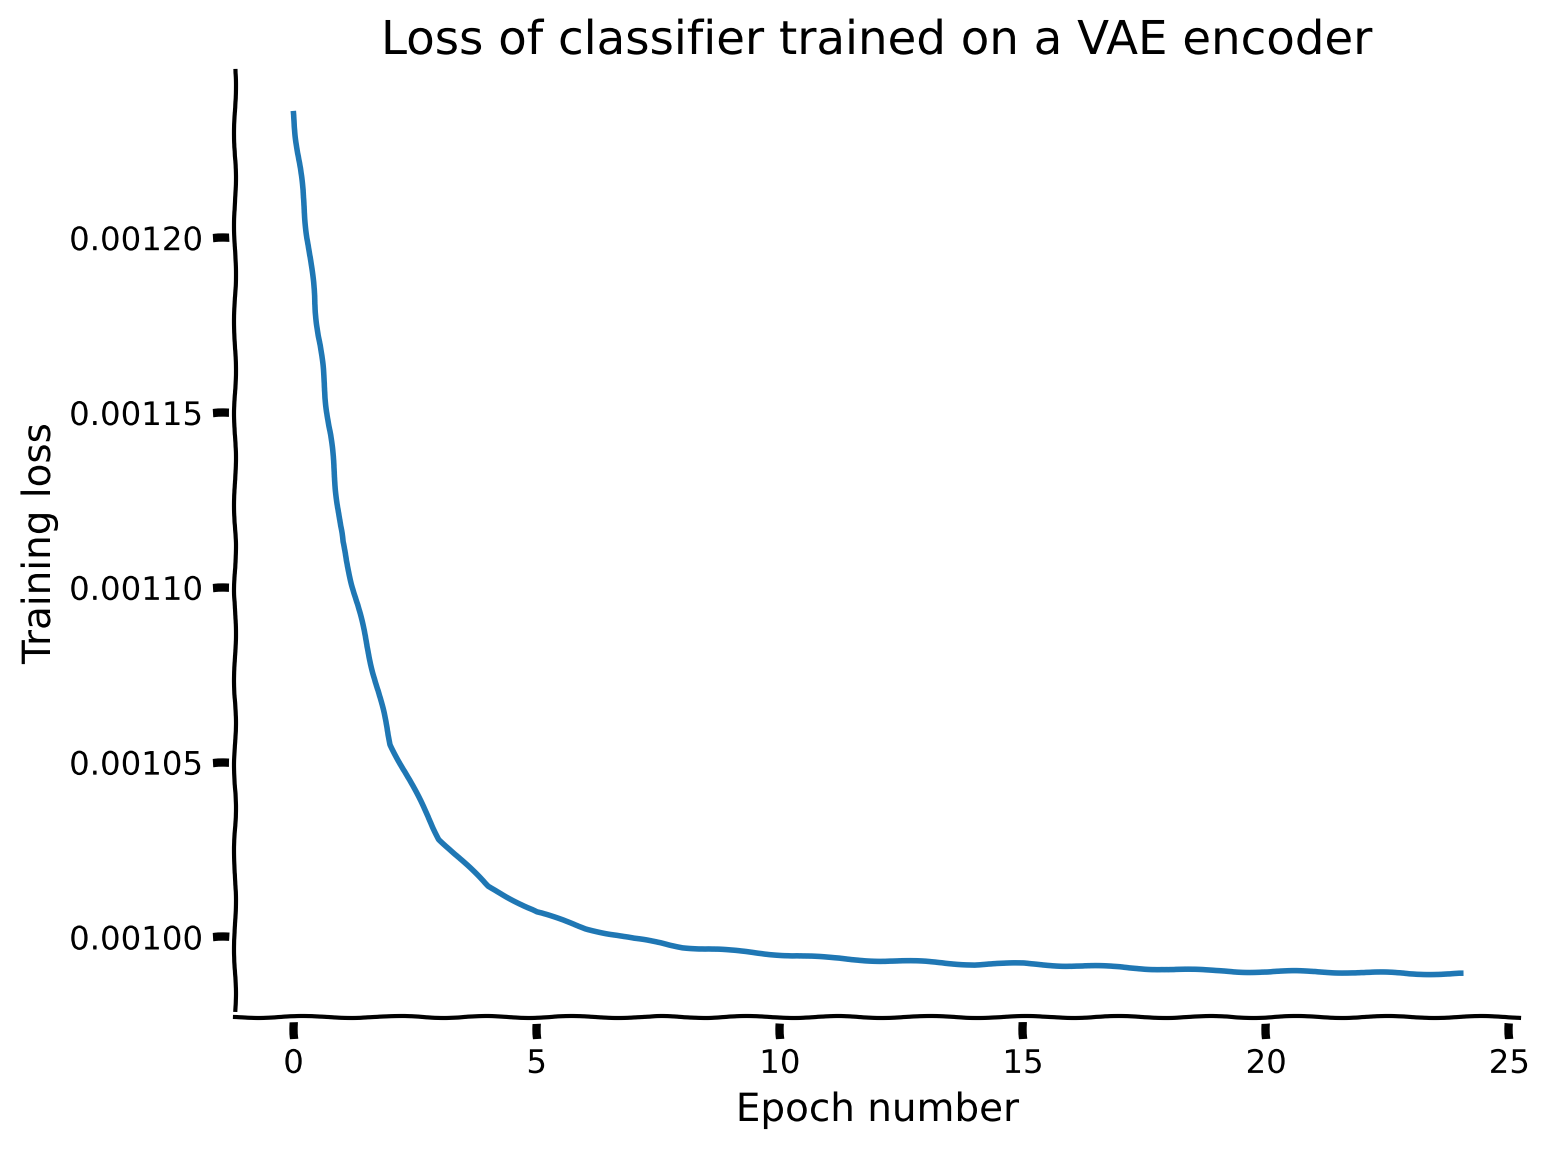

In [19]:
def vae_train_loss(num_epochs, seed):
  """
  Helper function to plot the train loss of the variational autoencoder (VAE)

  Args:
    num_epochs: Integer
      Number of the epochs the VAE is to be trained for
    seed: Integer
      The seed value for the dataset/network

  Returns:
    vae_loss_array: List
      Loss per epoch
  """
  # Call this before any dataset/network initializing or training,
  # to ensure reproducibility
  set_seed(seed)
  # Train an encoder and classifier on the images, using models.train_classifier()
  print("Training a classifier on the pre-trained VAE encoder representations...")
  _, vae_loss_array, _, _ = models.train_classifier(
      encoder=vae_encoder,
      dataset=dSprites_torchdataset,
      train_sampler=train_sampler,
      test_sampler=test_sampler,
      freeze_features=True, # Keep the encoder frozen while training the classifier
      num_epochs=num_epochs,
      verbose=True # Print results
      )

  # Plot the VAE classifier training loss.
  fig, ax = plt.subplots()
  ax.plot(vae_loss_array)
  ax.set_title("Loss of classifier trained on a VAE encoder")
  ax.set_xlabel("Epoch number")
  ax.set_ylabel("Training loss")

  return vae_loss_array



# Set a reasonable number of training epochs
num_epochs = 25
## Uncomment below to test your function
with plt.xkcd():
  vae_loss_array = vae_train_loss(num_epochs=num_epochs, seed=SEED)